## NAO calculation check

In this notebook, we compute NAO indices using monthly sea-level pressure (SLP) anomaly timeseries. For quick check, we do it only for one hindcasts. We first substract the mean SLP data from SLP values to correct for the model drift. Then, we compute NAO indices by computing SLP anomaly (normalised) differences between Azores ($36^{\circ}N-40^{\circ}N$, $28^{\circ}W-20^{\circ}W$) and Iceland ($63^{\circ}N-70^{\circ}N$, $25^{\circ}W-16^{\circ}W$) regions (see Dunstone et al. 2016, Nature GeoSci.).

$$ NAO = p_{\text{south}} - p_{\text{north}}$$

In [1]:
# Load libraries

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
ppdir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"

year = 2008

ds = []
for r in range(0,10):
    var_path = "s" + str(year) +"-r" + str(r+1) + "i1p1f2/Amon/psl/gn/files/d20200417/"
    d = xr.open_mfdataset(ppdir + var_path + "*.nc")
    ds.append(d)
    
ds = xr.concat(ds, dim='r')

print(ds)

<xarray.Dataset>
Dimensions:    (time: 125, r: 10, bnds: 2, lat: 324, lon: 432)
Coordinates:
  * time       (time) object 2008-11-16 00:00:00 ... 2019-03-16 00:00:00
  * lat        (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon        (lon) float64 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.7 359.6
Dimensions without coordinates: r, bnds
Data variables:
    time_bnds  (r, time, bnds) object dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    lat_bnds   (r, time, lat, bnds) float64 dask.array<chunksize=(1, 2, 324, 2), meta=np.ndarray>
    lon_bnds   (r, time, lon, bnds) float64 dask.array<chunksize=(1, 2, 432, 2), meta=np.ndarray>
    psl        (r, time, lat, lon) float32 dask.array<chunksize=(1, 2, 324, 432), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-05-2

In [10]:
ppdir_drift="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_1970_2016_Method_DCPP/"

ds_drift = []

for r in range (0,10):
    
    ds1 = []
    
    count = 0 
    
    for lead_year in range(0,11):
    
        d = xr.open_dataset(ppdir_drift + "psl/Drift_psl_r" + str(r+1) +"_Lead_Year_" + str(lead_year+1) + ".nc")
        #d = d.assign(time = np.arange(count, np.minimum(12 + count, len(d['time']) + count), 1))
        d = d.assign(time = np.arange(lead_year*12, 12*lead_year + np.minimum(12, len(d['time'])), 1))
        ds1.append(d)
    ds1 = xr.concat(ds1, dim='time')
    
    ds_drift.append(ds1)
    
ds_drift = xr.concat(ds_drift, dim='r')   

In [33]:
ds_drift = ds_drift.drop('time') 
#ds_drift['time'] = ds['time']

print(ds_drift)

<xarray.Dataset>
Dimensions:  (lat: 324, lon: 432, r: 10, time: 125)
Coordinates:
  * lat      (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon      (lon) float64 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.7 359.6
Dimensions without coordinates: r, time
Data variables:
    psl      (r, time, lat, lon) float32 1e+05 1e+05 1e+05 ... 1.02e+05 1.02e+05


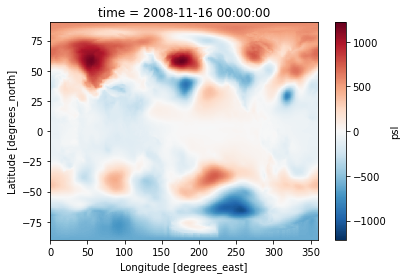

In [34]:
ds_anom = ds - ds_drift

ds_anom['psl'].isel(r=0,time=0).plot()

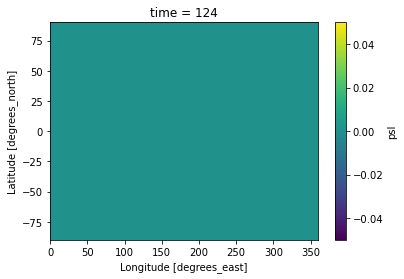

In [40]:
# Just to check that concat operation was perforemd correctly
(ds_drift['psl'].isel(r=9,time=124) - d['psl'].isel(time=4)).plot()

In [52]:
# Deltas to compute cell areas

RAD_EARTH = 6.387e6

ds_anom['dx'] = np.mean(ds_anom['lon'].diff('lon')) * np.cos(ds_anom['lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.)

ds_anom['dy'] = np.mean(ds_anom['lat'].diff('lat')) * (2 * np.pi * RAD_EARTH / 360.)


In [29]:
dA = ds_anom['dx'] * ds_anom['dy']
dA, tmp = xr.broadcast(dA, ds_anom['psl'].isel(r=0, time=0))

P_south = ((ds_anom['psl'] * dA).sel(lat = slice(36., 40.), lon = slice(332., 340.))).sum(['lat','lon']) / dA.sum()

P_north = ((ds_anom['psl'] * dA).sel(lat = slice(63., 70.), lon = slice(335., 344.))).sum(['lat','lon']) / dA.sum()

NAO = (P_south - P_south.mean('time')) / P_south.std('time') - (P_north - P_north.mean('time')) / P_north.std('time')

In [30]:
NAO = NAO.compute()

print(NAO)

<xarray.DataArray (r: 10, time: 125)>
array([[-0.69899034, -2.85619474, -2.41319294, ...,  3.6282727 ,
         0.93628391, -3.34873918],
       [ 0.0382826 , -2.3120681 ,  0.69672777, ...,  0.45887891,
         2.35991122, -0.62562154],
       [-1.80043028, -1.21982679, -1.59308742, ...,  0.680964  ,
         2.32619541,  2.36195715],
       ...,
       [-0.11505509,  3.00922897, -1.62522619, ...,  0.79496459,
        -0.19594515, -1.07459573],
       [ 0.41043924, -1.73996189,  0.76009702, ...,  1.41030551,
        -4.01633112, -1.99438767],
       [ 0.90106355, -4.26533754,  0.37588833, ..., -1.81401704,
        -2.73851364, -0.88198135]])
Coordinates:
  * time     (time) object 2008-11-16 00:00:00 ... 2019-03-16 00:00:00
Dimensions without coordinates: r


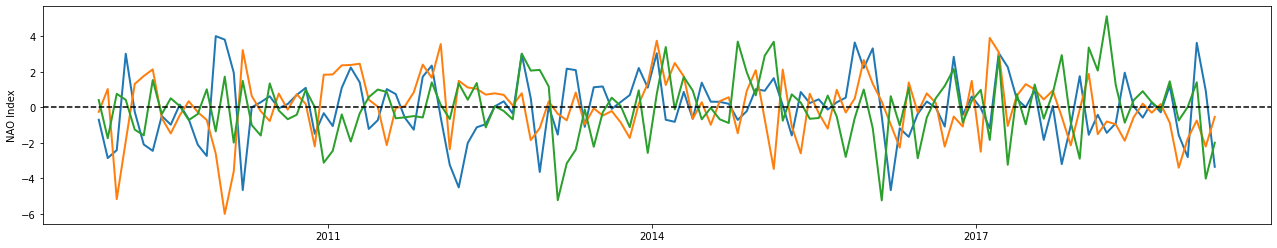

In [32]:
fig = plt.figure(figsize=[22,4])

for r in range (0,10,4):
    plt.plot(ds_anom['time'], NAO.isel(r=r), lw=2.)
plt.ylabel('NAO Index')
plt.axhline(y=0., ls='--', color='k')

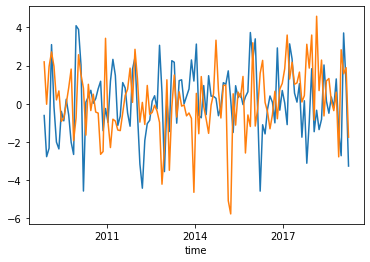

In [28]:
# This is without removing time mean in the above calculation.
# NAO time series looks alsmot the same, so we stick with removal of time mean.

NAO.isel(r=0).plot()
NAO.isel(r=5).plot()

In [53]:
print(ds_anom)

<xarray.Dataset>
Dimensions:  (time: 125, lat: 324, lon: 432, r: 10)
Coordinates:
  * time     (time) object 2008-11-16 00:00:00 ... 2019-03-16 00:00:00
  * lat      (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon      (lon) float64 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.7 359.6
Dimensions without coordinates: r
Data variables:
    psl      (r, time, lat, lon) float32 dask.array<chunksize=(1, 2, 324, 432), meta=np.ndarray>
    dx       (lat) float64 450.4 1.351e+03 2.252e+03 ... 1.351e+03 450.3
    dy       float64 6.193e+04


In [42]:
ds['time_val'] = ds['time']
ds = ds.drop('time')
print(ds)

<xarray.Dataset>
Dimensions:    (r: 10, time: 125, bnds: 2, lat: 324, lon: 432)
Coordinates:
  * lat        (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon        (lon) float64 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.7 359.6
Dimensions without coordinates: r, time, bnds
Data variables:
    time_bnds  (r, time, bnds) object dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    lat_bnds   (r, time, lat, bnds) float64 dask.array<chunksize=(1, 2, 324, 2), meta=np.ndarray>
    lon_bnds   (r, time, lon, bnds) float64 dask.array<chunksize=(1, 2, 432, 2), meta=np.ndarray>
    psl        (r, time, lat, lon) float32 dask.array<chunksize=(1, 2, 324, 432), meta=np.ndarray>
    time_val   (time) object 2008-11-16 00:00:00 ... 2019-03-16 00:00:00
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          202

In [44]:
print(tmp)

<xarray.DataArray 'psl' (lat: 324, lon: 432)>
dask.array<getitem, shape=(324, 432), dtype=float32, chunksize=(324, 432), chunktype=numpy.ndarray>
Coordinates:
    time     object 2008-11-16 00:00:00
  * lat      (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon      (lon) float64 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.7 359.6


In [57]:
dA = ds_anom['dx'] * ds_anom['dy']
dA, tmp = xr.broadcast(dA, ds_anom['psl'].isel(r=0, time=0))
print(dA, tmp)

<xarray.DataArray (lat: 324, lon: 432)>
array([[2.78913359e+07, 2.78913359e+07, 2.78913359e+07, ...,
        2.78913359e+07, 2.78913359e+07, 2.78913359e+07],
       [8.36713853e+07, 8.36713853e+07, 8.36713853e+07, ...,
        8.36713853e+07, 8.36713853e+07, 8.36713853e+07],
       [1.39443568e+08, 1.39443568e+08, 1.39443568e+08, ...,
        1.39443568e+08, 1.39443568e+08, 1.39443568e+08],
       ...,
       [1.39442037e+08, 1.39442037e+08, 1.39442037e+08, ...,
        1.39442037e+08, 1.39442037e+08, 1.39442037e+08],
       [8.36698534e+07, 8.36698534e+07, 8.36698534e+07, ...,
        8.36698534e+07, 8.36698534e+07, 8.36698534e+07],
       [2.78898038e+07, 2.78898038e+07, 2.78898038e+07, ...,
        2.78898038e+07, 2.78898038e+07, 2.78898038e+07]])
Coordinates:
  * lat      (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon      (lon) float64 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.7 359.6 <xarray.DataArray 'psl' (lat: 324, lon: 432)>
dask.array<getitem, shap

## Check NAO indices

Here, we check compute NAO indices, which were computed using the above algorithm (see python script in Python_Scripts folder), for all hindcasts. We also comapre them against surface heat flux anomalies and SST anomalies.

In [4]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

ds_anom = []

var_list2 = ['hfds', 'tos']

for var in var_list2:
    
    ds = []
    
    for i in range(0,10):
    
        d = xr.open_dataset(ppdir + "DJF_only/Anomaly_" + var + "_r" + str(i+1) + ".nc")
        
        ds.append(d)
    
    ds = xr.concat(ds, dim='r')
    
    ds_anom.append(ds)

ds_anom = xr.concat(ds_anom, dim='var')

print(ds_anom, ds_NAO)


<xarray.Dataset>
Dimensions:            (var: 2, r: 10, start_year: 57, lead_year: 11)
Dimensions without coordinates: var, r, start_year, lead_year
Data variables:
    Labrador_Sea       (var, r, start_year, lead_year) float32 4.522 ... 0.04722
    Irminger_Sea       (var, r, start_year, lead_year) float32 43.33 ... 0.2948
    Iceland_Basin      (var, r, start_year, lead_year) float32 19.4 ... 0.2534
    North_East_Region  (var, r, start_year, lead_year) float32 2.923 ... 0.7693
    South_West_Region  (var, r, start_year, lead_year) float32 -30.96 ... 0.5709
    South_East_Region  (var, r, start_year, lead_year) float32 -6.573 ... 0.0...
    North_Atlantic     (var, r, start_year, lead_year) float32 -9.218 ... 0.5627 <xarray.Dataset>
Dimensions:     (start_year: 57, r: 10, time: 125)
Coordinates:
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
Dimensions without coordinates: r, time
Data variables:
    NAO         (start_year, r, time) float64 ...
    P_

In [33]:
NAO = ds_NAO['NAO'].copy()
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO = NAO.assign_coords(time=tim)

NAO = NAO.resample(time='QS-DEC').mean('time')
NAO = NAO.sel(time = NAO['time.season'] == 'DJF')

NAO = NAO.rename({'time': 'lead_year'}).drop('lead_year')
#NAO = NAO.assign_coords(start_year = ds_anom.start_year)

print(NAO)

<xarray.DataArray 'NAO' (start_year: 57, r: 10, lead_year: 11)>
array([[[-3.52676437, -1.59789143, -1.94774649, ...,  2.37269632,
          0.29412711, -1.98698763],
        [-1.52204035, -0.90297757, -2.89238188, ..., -1.06972571,
         -1.29989224, -1.4705903 ],
        [ 0.53243847, -0.94058565,  1.79087873, ...,  3.38792277,
          1.42839777, -0.14144109],
        ...,
        [ 0.34436613, -0.35130923, -0.32276817, ...,  1.87281069,
         -2.49393893,  1.36365063],
        [ 2.87569453, -4.84856511,  1.23311817, ...,  1.7627209 ,
          1.50897168,  0.40925804],
        [ 0.04308736, -1.46277565,  2.52841427, ...,  1.67886183,
         -1.93633636,  1.49538293]],

       [[ 1.49540622,  0.61045862,  0.45507832, ...,  0.17298303,
          0.04098368, -0.1076437 ],
        [-0.20859312, -1.43061465, -1.94411466, ...,  2.40825141,
          2.53087104,  0.80161716],
        [-0.04749056, -2.96425487, -0.12106945, ..., -1.32618104,
          0.98583771,  2.54005371],
...

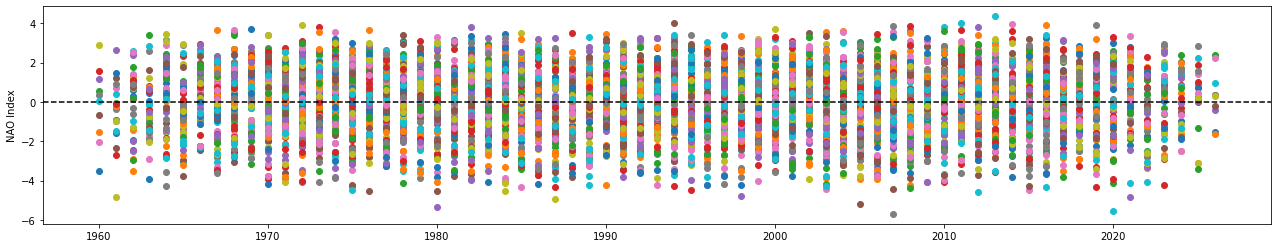

In [40]:
fig = plt.figure(figsize=[22,4])

for start_year in range(1960, 2017):
    for r in range (0,10):
        plt.plot(NAO['lead_year'] + start_year, NAO.isel(r=r).sel(start_year=start_year), 'o')
plt.ylabel('NAO Index')
plt.axhline(y=0., ls='--', color='k')

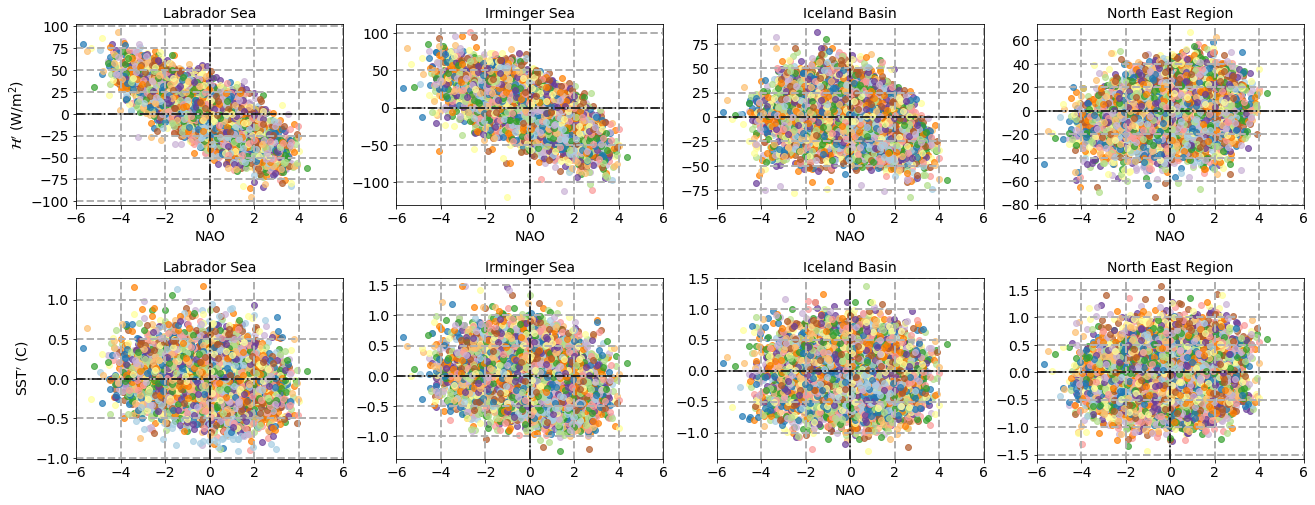

In [42]:
grid = plt.GridSpec(2, 4, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[22,8])

region_list = ['Labrador_Sea', 'Irminger_Sea', 'Iceland_Basin', 'North_East_Region']
tilt_name = ['Labrador Sea', 'Irminger Sea', 'Iceland Basin', 'North East Region']

var_list = ['hfds', 'tos']

col = plt.cm.Paired(np.linspace(0.,1., 11))

i =0 
for region in region_list:
    j =0 
    for var in var_list:
        
        ax = fig.add_subplot(grid[j, i])
        
        for start_year in range(0, len(NAO.start_year), 1):
            for lead_year in range(0,11):
                
                ax.scatter(NAO.isel(start_year=start_year, lead_year=lead_year), 
                           ds_anom[region].isel(var = j, start_year=start_year, lead_year=lead_year), color=col[lead_year], alpha=0.7)
                ax.grid('on', lw=2, ls='--')
        
        if(i==0 and j==0):
            ax.set_ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$)', fontsize=14)
        elif(i==0 and j==1):
            ax.set_ylabel(r'SST$^{\prime}$ (C)', fontsize=14)
        ax.set_xlabel(r'NAO', fontsize=14)
        ax.axhline(y=0.0, color="k", linestyle="-.") 
        ax.axvline(x=0.0, color="k", linestyle="-.") 
        ax.set_xlim([-6., 6.])
        #ax.set_ylim([-120., 120.])
        ax.set_title(tilt_name[i], fontsize=14)
        plt.yticks(fontsize = 14)
        plt.xticks(fontsize = 14)
        
        j = j + 1
    i = i+1

In figure 1, NAO indices look very random and there is no trend. This is not unusual and seen in ensemble runs. 

In the last figure, negative NAO phases seem to have a strong negative correlattion with surface heat flux anomaly (positive -> more heat loss from the ocean) in Labrador and Irminger. This looks reasonable as jet stream tends to be stronger in a positive NAO phase (somtimes more northward shifted). This behavior leads more heat loss from the ocean to atmosphere. 

However, there is no clear dependence with SST anomaly. This is probably because SST are also affected by heat fluxes into the regions and need not have clear one-to-one dependence to NAO indices. Also, there could be time lags involved.